# [作業目標]
- 使用 Day 17 剛學到的方法, 對較完整的資料生成離散化特徵
- 觀察上述離散化特徵, 對於目標值的預測有沒有幫助

# [作業重點]
- 仿照 Day 17 的語法, 將年齡資料 ('DAYS_BIRTH' 除以 365) 離散化
- 繪製上述的 "離散化標籤" 與目標值 ('TARGET') 的長條圖

In [1]:
# 載入需要的套件
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns # 另一個繪圖-樣式套件


# 忽略警告訊息
import warnings
warnings.filterwarnings('ignore')
# 設定 data_path
dir_data = './data/'

### 之前做過的處理

In [2]:
# 讀取資料檔
f_app_train = os.path.join(dir_data, 'application_train.csv')
app_train = pd.read_csv(f_app_train)
app_train.shape

(307511, 122)

In [3]:
# 將只有兩種值的類別型欄位, 做 Label Encoder, 計算相關係數時讓這些欄位可以被包含在內
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

# 檢查每一個 column
for col in app_train:
    if app_train[col].dtype == 'object':
        # 如果只有兩種值的類別型欄位
        if len(list(app_train[col].unique())) <= 2:
            # 就做 Label Encoder, 以加入相關係數檢查
            app_train[col] = le.fit_transform(app_train[col])            
print(app_train.shape)
app_train.head()

(307511, 122)


,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,0,M,0,1,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,0,F,0,0,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,1,M,1,1,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,0,F,0,1,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,0,M,0,1,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


In [4]:
# 受雇日數為異常值的資料, 另外設一個欄位記錄, 並將異常的日數轉成空值 (np.nan)
app_train['DAYS_EMPLOYED_ANOM'] = app_train["DAYS_EMPLOYED"] == 365243
app_train['DAYS_EMPLOYED'].replace({365243: np.nan}, inplace = True)

# 出生日數 (DAYS_BIRTH) 取絕對值 
app_train['DAYS_BIRTH'] = abs(app_train['DAYS_BIRTH'])

## 練習時間
參考 Day 17 範例程式，離散化你覺得有興趣的欄位，並嘗試找出有趣的訊息

In [5]:
#找出與年齡有關的相關函數
print('負相關 top 15',app_train.corr()['DAYS_BIRTH'].sort_values().head(15))
print('正相關 top 15',app_train.corr()['DAYS_BIRTH'].sort_values(ascending=False).head(15))

負相關 top 15 FLAG_EMP_PHONE               -0.619888
DAYS_EMPLOYED                -0.352321
DAYS_REGISTRATION            -0.331912
CNT_CHILDREN                 -0.330938
CNT_FAM_MEMBERS              -0.278894
DAYS_ID_PUBLISH              -0.272691
REG_CITY_NOT_WORK_CITY       -0.242401
REG_CITY_NOT_LIVE_CITY       -0.180382
FLAG_WORK_PHONE              -0.172457
LIVE_CITY_NOT_WORK_CITY      -0.158882
FLAG_OWN_CAR                 -0.129879
FLAG_DOCUMENT_8              -0.113243
FLAG_DOCUMENT_3              -0.109666
REG_REGION_NOT_WORK_REGION   -0.095819
HOUR_APPR_PROCESS_START      -0.091064
Name: DAYS_BIRTH, dtype: float64
正相關 top 15 DAYS_BIRTH                    1.000000
DAYS_EMPLOYED_ANOM            0.619947
EXT_SOURCE_1                  0.600610
FLAG_DOCUMENT_6               0.407160
EXT_SOURCE_3                  0.205478
FLAG_OWN_REALTY               0.119146
EXT_SOURCE_2                  0.091996
AMT_REQ_CREDIT_BUREAU_YEAR    0.071983
AMT_CREDIT                    0.055436
AMT_GOODS

In [6]:
#觀察TARGET 年齡與FLAG_OWN_CAR的關係

app_train['FLAG_OWN_CAR'].fillna(0)#缺值補0
age_data = app_train[['TARGET','FLAG_OWN_CAR', 'DAYS_BIRTH']] # subset
age_data['YEARS_BIRTH'] = abs(age_data['DAYS_BIRTH'])/365

bin_cut = 11 
age_data['YEARS_BINNED'] = pd.cut(age_data['YEARS_BIRTH'], bins = bin_cut) 
# 顯示不同組的數量
print(age_data['YEARS_BINNED'].value_counts())
age_data.head()

(38.192, 42.61]     38108
(33.773, 38.192]    36195
(29.355, 33.773]    35088
(42.61, 47.028]     34019
(51.447, 55.865]    31287
(47.028, 51.447]    29772
(55.865, 60.284]    29229
(24.936, 29.355]    28156
(60.284, 64.702]    24079
(20.469, 24.936]    11860
(64.702, 69.121]     9718
Name: YEARS_BINNED, dtype: int64


,TARGET,FLAG_OWN_CAR,DAYS_BIRTH,YEARS_BIRTH,YEARS_BINNED
0,1,0,9461,25.920548,"(24.936, 29.355]"
1,0,0,16765,45.931507,"(42.61, 47.028]"
2,0,1,19046,52.180822,"(51.447, 55.865]"
3,0,0,19005,52.068493,"(51.447, 55.865]"
4,0,0,19932,54.608219,"(51.447, 55.865]"


In [13]:
test_df= age_data.groupby(['YEARS_BINNED','FLAG_OWN_CAR'])
test_df['TARGET'].describe()

count      mean       std  min  25%  50%  \
YEARS_BINNED     FLAG_OWN_CAR                                               
(20.469, 24.936] 0              8104.0  0.127221  0.333241  0.0  0.0  0.0   
                 1              3756.0  0.116613  0.321002  0.0  0.0  0.0   
(24.936, 29.355] 0             17461.0  0.121814  0.327081  0.0  0.0  0.0   
                 1             10695.0  0.092473  0.289706  0.0  0.0  0.0   
(29.355, 33.773] 0             20854.0  0.118778  0.323535  0.0  0.0  0.0   
                 1             14234.0  0.085781  0.280050  0.0  0.0  0.0   
(33.773, 38.192] 0             21374.0  0.105081  0.306665  0.0  0.0  0.0   
                 1             14821.0  0.078335  0.268707  0.0  0.0  0.0   
(38.192, 42.61]  0             22859.0  0.089024  0.284785  0.0  0.0  0.0   
                 1             15249.0  0.070496  0.255990  0.0  0.0  0.0   
(42.61, 47.028]  0             21100.0  0.085213  0.279205  0.0  0.0  0.0   
                 1             12919.0  0.063163  0.243265  0.0  0.0  0.0   
(47.028, 51.447] 0             19568.0  0.077780  0.267832  0.0  0.0  0.0   
                 1             10204.0  0.061936  0.241052  0.0  0.0  0.0   
(51.447, 55.865] 0             21908.0  0.064634  0.245884  0.0  0.0  0.0   
                 1              9379.0  0.060454  0.238339  0.0  0.0  0.0   
(55.865, 60.284] 0             22078.0  0.055530  0.229018  0.0  0.0  0.0   
                 1              7151.0  0.053000  0.224048  0.0  0.0  0.0   
(60.284, 64.702] 0             19350.0  0.053075  0.224189  0.0  0.0  0.0   
                 1              4729.0  0.051174  0.220375  0.0  0.0  0.0   
(64.702, 69.121] 0              8268.0  0.041606  0.199700  0.0  0.0  0.0   
                 1              1450.0  0.038621  0.192756  0.0  0.0  0.0   

                               75%  max  
YEARS_BINNED     FLAG_OWN_CAR            
(20.469, 24.936] 0             0.0  1.0  
                 1             0.0  1.0  
(24.936, 29.355] 0             0.0  1.0  
                 1             0.0  1.0  
(29.355, 33.773] 0             0.0  1.0  
                 1             0.0  1.0  
(33.773, 38.192] 0             0.0  1.0  
                 1             0.0  1.0  
(38.192, 42.61]  0             0.0  1.0  
                 1             0.0  1.0  
(42.61, 47.028]  0             0.0  1.0  
                 1             0.0  1.0  
(47.028, 51.447] 0             0.0  1.0  
                 1             0.0  1.0  
(51.447, 55.865] 0             0.0  1.0  
                 1             0.0  1.0  
(55.865, 60.284] 0             0.0  1.0  
                 1             0.0  1.0  
(60.284, 64.702] 0             0.0  1.0  
                 1             0.0  1.0  
(64.702, 69.121] 0             0.0  1.0  
                 1             0.0  1.0

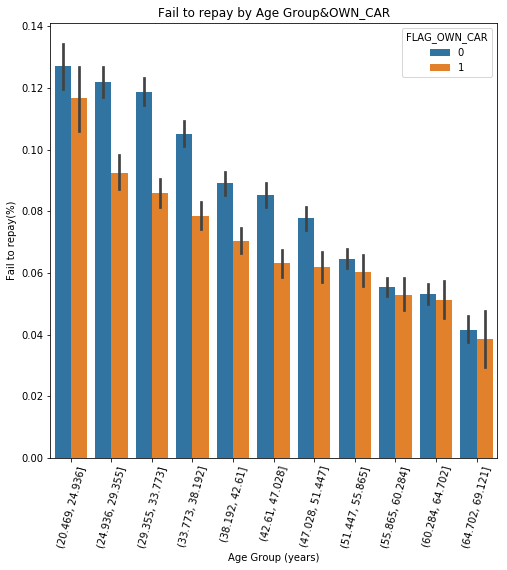

In [22]:
plt.figure(figsize = (8, 8))

# 以年齡區間為 x, target 為 y 繪製 barplot,在加進有無車輛進行分析

px = age_data['YEARS_BINNED']
py = age_data['TARGET']
hue_p= age_data['FLAG_OWN_CAR']
sns.barplot(px, py,hue = hue_p)

# Plot labeling
plt.xticks(rotation = 75); plt.xlabel('Age Group (years)'); plt.ylabel('Fail to repay(%)')
plt.title('Fail to repay by Age Group&OWN_CAR');

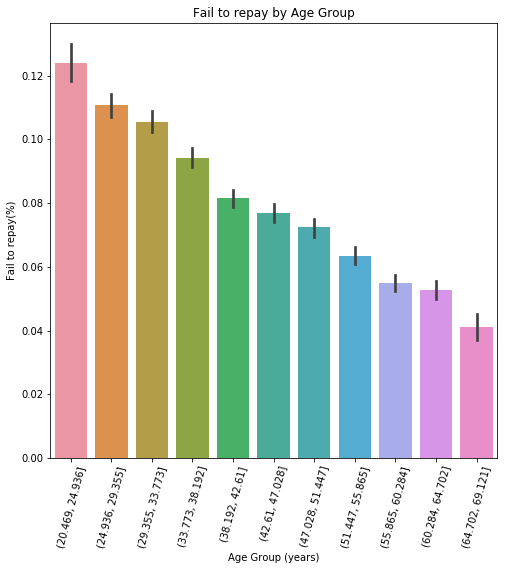

In [15]:
plt.figure(figsize = (8, 8))

# 以年齡區間為 x, target 為 y 繪製 barplot

px = age_data['YEARS_BINNED']
py = age_data['TARGET']
sns.barplot(px, py)

# Plot labeling
plt.xticks(rotation = 75); plt.xlabel('Age Group (years)'); plt.ylabel('Fail to repay(%)')
plt.title('Fail to repay by Age Group');

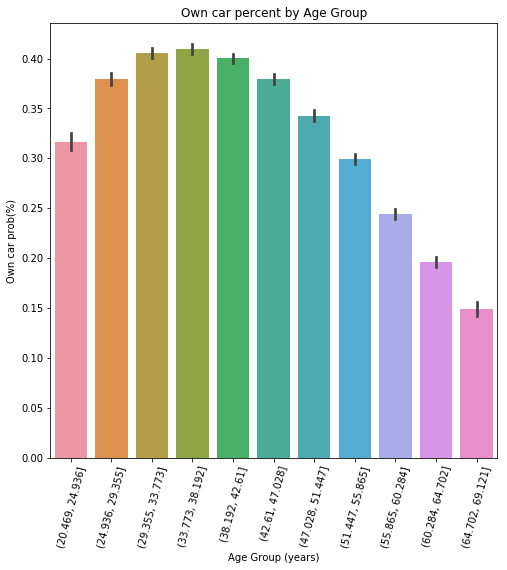

In [9]:
plt.figure(figsize = (8, 8))

# 以年齡區間為 x, target 為 y 繪製 barplot

px = age_data['YEARS_BINNED']
py = age_data['FLAG_OWN_CAR']
sns.barplot(px, py)

# Plot labeling
plt.xticks(rotation = 75); plt.xlabel('Age Group (years)'); plt.ylabel('Own car prob(%)')
plt.title('Own car percent by Age Group');